In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pickle
from models import NonLinearModel, NonLinearController, ClosedLoopSystem
from contractive_REN import ContractiveREN
from utils import set_params
from dataset import SystemIdentificationDataset
from torch.utils.data import DataLoader, random_split

In [3]:
# Define simulation parameters
x0, input_dim, state_dim, output_dim, input_noise_std, output_noise_std, horizon, num_signals, batch_size, ts, learning_rate, epochs, n_xi, l = set_params()

#-------------------------1. Create the plant and controller------------------------------------
sys = NonLinearModel(state_dim=state_dim, input_dim=input_dim, output_dim=output_dim, output_noise_std=output_noise_std)
controller = NonLinearController(input_K_dim=output_dim, output_K_dim=input_dim)
closed_loop = ClosedLoopSystem(sys, controller)

In [4]:
#-------------------------2. Generate closed loop data---------------------------------------------
dataset = SystemIdentificationDataset(num_signals = num_signals, horizon = horizon, input_dim = input_dim, state_dim = state_dim, output_dim = output_dim, closed_loop = closed_loop, input_noise_std = input_noise_std, fixed_x0 = x0)

# Compute split sizes
train_size = int(num_signals/2)
val_size = int(num_signals/4)
test_size = int(num_signals/4)

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#training data
external_input_data = dataset.external_input_data
plant_input_data = dataset.plant_input_data
output_data = dataset.output_data

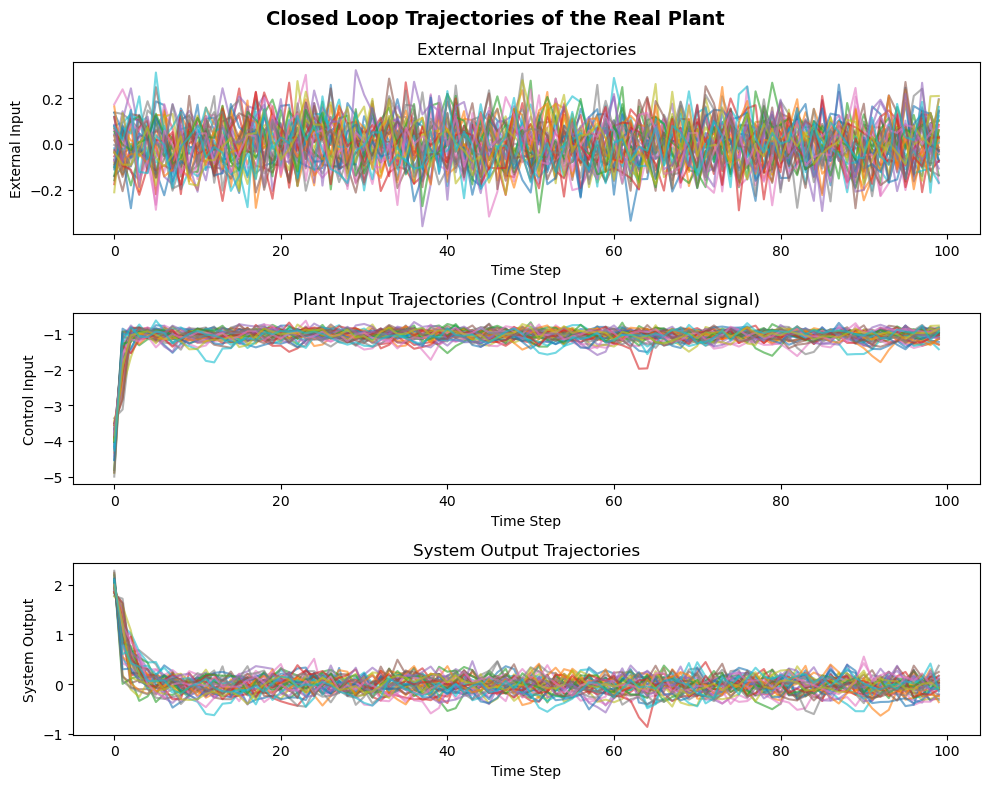

In [5]:
#-------------------------plot closed loop training data---------------------------------------------------

# Convert tensors to numpy for plotting
external_input_np = external_input_data.detach().numpy()
plant_input_np = plant_input_data.detach().numpy()
output_np = output_data.detach().numpy()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Plot External Inputs
for i in range(input_dim):
    axes[0].plot(external_input_np[:, :, i].T, alpha=0.6)
axes[0].set_title("External Input Trajectories")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("External Input")

# Plot Plant Inputs (Controller Outputs)
for i in range(input_dim):
    axes[1].plot(plant_input_np[:, :, i].T, alpha=0.6)
axes[1].set_title("Plant Input Trajectories (Control Input + external signal)")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Control Input")

# Plot System Outputs
for i in range(output_dim):
    axes[2].plot(output_np[:, :, i].T, alpha=0.6)
axes[2].set_title("System Output Trajectories")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")

fig.suptitle("Closed Loop Trajectories of the Real Plant", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [6]:
#--------------------------3. Define model for sysid---------------------------------------------
#create the REN model for G
y_init = x0
REN_G = ContractiveREN(dim_in= input_dim, dim_out= output_dim, dim_internal=n_xi, dim_nl= l, y_init = y_init)

#--------------------------4. Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()

optimizer = torch.optim.Adam(REN_G.parameters(), lr=learning_rate)
optimizer.zero_grad()

/Users/laurameroi/Desktop/Nonlinear_system_identification/contractive_REN.py:86: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_581jc0ddx6/croot/pytorch-select_1730848714937/work/aten/src/ATen/native/TensorShape.cpp:3679.)
  self.x = torch.linalg.lstsq(self.C2, y_init.to(self.C2.device).squeeze(1).T)[0].T


In [ ]:
#--------------------------5. Training---------------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
REN_G.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs
for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_G.train()
    loss_epoch = 0.0  # Accumulate training loss

    for u_batch, y_batch in train_loader:
        u_batch, y_batch = u_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        REN_G.reset()
        y_hat_train_G = REN_G(u_batch)
        loss_batch = MSE(y_hat_train_G, y_batch)


        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_G.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u_batch, y_batch in val_loader:
            u_batch, y_batch = u_batch.to(device), y_batch.to(device)
            REN_G.reset()

            y_hat_val = REN_G(u_batch)
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

# Save the trained model
torch.save(REN_G.state_dict(), 'REN_G_trained_model.pth')

Epoch: 1 	||	 Training Loss: 0.114291 	||	 Validation Loss: 0.053092
Epoch: 2 	||	 Training Loss: 0.052947 	||	 Validation Loss: 0.053043
Epoch: 3 	||	 Training Loss: 0.050994 	||	 Validation Loss: 0.043430
Epoch: 4 	||	 Training Loss: 0.041511 	||	 Validation Loss: 0.040459
Epoch: 5 	||	 Training Loss: 0.039957 	||	 Validation Loss: 0.038538
Epoch: 6 	||	 Training Loss: 0.037751 	||	 Validation Loss: 0.036491
Epoch: 7 	||	 Training Loss: 0.036891 	||	 Validation Loss: 0.035720
Epoch: 8 	||	 Training Loss: 0.036114 	||	 Validation Loss: 0.035274
Epoch: 9 	||	 Training Loss: 0.035689 	||	 Validation Loss: 0.034898
Epoch: 10 	||	 Training Loss: 0.035264 	||	 Validation Loss: 0.034537
Epoch: 11 	||	 Training Loss: 0.034933 	||	 Validation Loss: 0.034309
Epoch: 12 	||	 Training Loss: 0.034691 	||	 Validation Loss: 0.033914
Epoch: 13 	||	 Training Loss: 0.034306 	||	 Validation Loss: 0.033593
Epoch: 14 	||	 Training Loss: 0.034039 	||	 Validation Loss: 0.033402
Epoch: 15 	||	 Training Loss:

In [ ]:
# --------------Plot identification results for G-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model's Predictions vs Actual Output for the training set
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True, sharey=True)

for i in range(3):  # Choose 3 batches from training data
    sample_u_batch, sample_y_batch = next(iter(train_loader))  # Get a sample batch
    sample_u_batch, sample_y_batch = sample_u_batch.to(device), sample_y_batch.to(device)

    # Plot comparison between real and predicted for training set
    REN_G.eval()

    y_hat = REN_G(sample_u_batch)

    # Convert to numpy for plotting
    y_batch_np = sample_y_batch.detach().cpu().numpy()
    y_hat_np = y_hat.detach().cpu().numpy()

    # Time array for plotting
    time_plot = np.arange(0, sample_u_batch.shape[1] * ts, ts)

    # Plot comparison for each signal
    axes[i].plot(time_plot, y_batch_np[0, :, 0], label="Real Output", color="blue")
    axes[i].plot(time_plot, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
    axes[i].set_title(f"Train Set - Sample {i+1}")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Output Value")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Real vs Predicted Output for Training Set for G")
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True, sharey=True)

for i in range(3):  # Choose 3 batches from test data
    sample_u_batch, sample_y_batch = next(iter(test_loader))  # Get a sample batch
    sample_u_batch, sample_y_batch = sample_u_batch.to(device), sample_y_batch.to(device)

    # Plot comparison between real and predicted for test set
    REN_G.eval()

    y_hat = REN_G(sample_u_batch)

    # Convert to numpy for plotting
    y_batch_np = sample_y_batch.detach().cpu().numpy()
    y_hat_np = y_hat.detach().cpu().numpy()

    # Time array for plotting
    time_plot = np.arange(0, sample_u_batch.shape[1] * ts, ts)

    # Plot comparison for each signal
    axes[i].plot(time_plot, y_batch_np[0, :, 0], label="Real Output", color="blue")
    axes[i].plot(time_plot, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
    axes[i].set_title(f"Test Set - Sample {i+1}")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Output Value")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Real vs Predicted Output for Test Set for G")
plt.tight_layout()
plt.show()

In [ ]:
#-------------------------plot open loop simulation of the real plant and the identified model G----------------------------------------------------
u_OL = torch.randn((num_signals, horizon, input_dim)) * input_noise_std
y_OL = sys(x0 = x0, u_ext = u_OL)

REN_G.eval()
REN_G.reset()
y_OL_G = REN_G(u_OL)

# Convert tensors to numpy for plotting
u_OL = u_OL.detach().numpy()
y_OL = y_OL.detach().numpy()
y_OL_G = y_OL_G.detach().numpy()

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot Plant Inputs
for i in range(input_dim):
    axes[0].plot(u_OL[:, :, i].T, alpha=0.6)
axes[0].set_title("Plant Input Trajectories (Control Inputs)")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Control Input")

# Plot Plant Outputs
for i in range(output_dim):
    axes[1].plot(y_OL[:, :, i].T, alpha=0.6)
axes[1].set_title("Real plant Output Trajectories")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("System Output")

# Plot Plant Outputs
for i in range(output_dim):
    axes[2].plot(y_OL_G[:, :, i].T, alpha=0.6)
axes[2].set_title("Identified model G Output Trajectories")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")

fig.suptitle("Open Loop Trajectories of the Real Plant and the identified model G", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [ ]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S
y_init = x0
REN_S = ContractiveREN(dim_in = input_dim, dim_out = output_dim, dim_internal = n_xi, dim_nl = l, y_init = y_init)
closed_loop_REN = ClosedLoopSystem(REN_S, controller)

#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()

optimizer = torch.optim.Adam(REN_S.parameters(), lr=learning_rate)
optimizer.zero_grad()

In [ ]:
#--------------------------5. Training---------------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
REN_S.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs

for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    closed_loop_REN.train()
    loss_epoch = 0.0  # Accumulate training loss

    for u_batch, y_batch in train_loader:
        u_batch, y_batch = u_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        #TODO: input x0 is not needed in the closed loop of REN and controller
        _, y_hat_train_S = closed_loop_REN(x0, u_batch)

        if torch.isnan(y_hat_train_S).any() or torch.isinf(y_hat_train_S).any():
            y_hat_train_S = torch.nan_to_num(y_hat_train_S, nan=1e5, posinf=1e5, neginf=-1e5)
            for name, param in closed_loop_REN.named_parameters():
                print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")

        loss_batch = MSE(y_hat_train_S, y_batch)

        loss_batch.backward()

        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    closed_loop_REN.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u_batch, y_batch in val_loader:
            u_batch, y_batch = u_batch.to(device), y_batch.to(device)

            _, y_hat_val = closed_loop_REN(x0, u_batch)

            if torch.isnan(y_hat_val).any() or torch.isinf(y_hat_val).any():
                y_hat_val = torch.nan_to_num(y_hat_val, nan=1e5, posinf=1e5, neginf=-1e5)
                for name, param in closed_loop_REN.named_parameters():
                    print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")

            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

# Save the trained model
torch.save(REN_S.state_dict(), 'REN_S_trained_model.pth')

In [ ]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model's Predictions vs Actual Output for the training set
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True, sharey=True)

for i in range(3):  # Choose 3 batches from training data
    sample_u_batch, sample_y_batch = next(iter(train_loader))  # Get a sample batch
    sample_u_batch, sample_y_batch = sample_u_batch.to(device), sample_y_batch.to(device)

    # Plot comparison between real and predicted for training set
    closed_loop_REN.eval()

    _, y_hat = closed_loop_REN(x0, sample_u_batch)

    # Convert to numpy for plotting
    y_batch_np = sample_y_batch.detach().cpu().numpy()
    y_hat_np = y_hat.detach().cpu().numpy()

    # Time array for plotting
    time_plot = np.arange(0, sample_u_batch.shape[1] * ts, ts)

    # Plot comparison for each signal
    axes[i].plot(time_plot, y_batch_np[0, :, 0], label="Real Output", color="blue")
    axes[i].plot(time_plot, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
    axes[i].set_title(f"Train Set - Sample {i+1}")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Output Value")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Real vs Predicted Output for Training Set for S")
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True, sharey=True)

for i in range(3):  # Choose 3 batches from test data
    sample_u_batch, sample_y_batch = next(iter(test_loader))  # Get a sample batch
    sample_u_batch, sample_y_batch = sample_u_batch.to(device), sample_y_batch.to(device)

    # Plot comparison between real and predicted for test set
    closed_loop_REN.eval()

    _, y_hat = closed_loop_REN(x0, sample_u_batch)

    # Convert to numpy for plotting
    y_batch_np = sample_y_batch.detach().cpu().numpy()
    y_hat_np = y_hat.detach().cpu().numpy()

    # Time array for plotting
    time_plot = np.arange(0, sample_u_batch.shape[1] * ts, ts)

    # Plot comparison for each signal
    axes[i].plot(time_plot, y_batch_np[0, :, 0], label="Real Output", color="blue")
    axes[i].plot(time_plot, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
    axes[i].set_title(f"Test Set - Sample {i+1}")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Output Value")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Real vs Predicted Output for Test Set for S")
plt.tight_layout()
plt.show()

In [ ]:
#-------------------------plot open loop simulation of the real plant and the identified model S in closed loop with K----------------------------------------------------
u_OL = torch.randn((num_signals, horizon, input_dim)) * input_noise_std
y_OL = sys(x0 = x0, u_ext = u_OL)

closed_loop_REN.eval()
_, y_OL_S = closed_loop_REN(x0, u_OL)

# Convert tensors to numpy for plotting
u_OL = u_OL.detach().numpy()
y_OL = y_OL.detach().numpy()
y_OL_S = y_OL_S.detach().numpy()

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot Plant Inputs
for i in range(input_dim):
    axes[0].plot(u_OL[:, :, i].T, alpha=0.6)
axes[0].set_title("Plant Input Trajectories (Control Inputs)")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Control Input")

# Plot Plant Outputs
for i in range(output_dim):
    axes[1].plot(y_OL[:, :, i].T, alpha=0.6)
axes[1].set_title("Real plant Output Trajectories")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("System Output")

# Plot Plant Outputs
for i in range(output_dim):
    axes[2].plot(y_OL_S[:, :, i].T, alpha=0.6)
axes[2].set_title("Identified model S Output Trajectories")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")

fig.suptitle("Open Loop Trajectories of the Real Plant and the identified model S", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()